# **CS482 Final Project**
### **Written by:** Diane Hamilton and Aadya Kamath
### **Due:** May 13, 2025

## **Topic:** FungiCLEF25 @ CVPR-FGVC & LifeCLEF

##**Overview**
The FungiCLEF Challenge focuses on few-shot recognition of fungi species using real-world observational data. Each observation includes multiple photographs of the same specimen, along with metadata (e.g., location, timestamp, substrate, habitat, toxicity), satellite imagery and meteorological variables.
<p>
The goal of the challenge is to develop a classification model capable of returning a ranked list of predicted species for each observation. A key challenge lies in handling a large number of species consisted of rare and under-recorded taxa with very few training examples.

**Input:** A list of fungi observations.
**Output:** A list of Top-k predicted fungi species from a predefined set of classes.

**Kagle Link**: https://www.kaggle.com/competitions/fungi-clef-2025


# 🔬 **0: Setup Steps**

In this section, we carry out installations that are necessary for performing the tasks we will be performing in this project.

##**📌 Tools to keep in mind**

PyTorch or TensorFlow for modeling

Hugging Face transformers for text

sklearn/pandas for tabular preprocessing

albumentations or timm for data augmentation

Faiss for embedding similarity search (rare species)

In [ ]:
#pip install our desired model
#pip install other packages or libraries we need

import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import v2

In [ ]:
# import helpers we built
from constants import *
import load_data
from fungi_dataloader import MultimodalDataset

##🤔**1: Understand the Problem**

**Goal:** Rank fungi species per observation (i.e., not just top-1 accuracy).

**Challenge:** Many classes (2,000+), most with very few examples (1–4).

**Opportunity:** Rich metadata (temporal, spatial, environmental) and image captions to augment vision data.

Azure Blob Storage Python quickstart sample


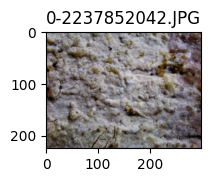

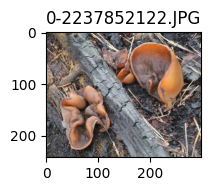

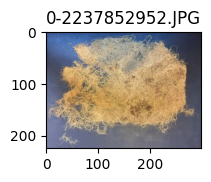

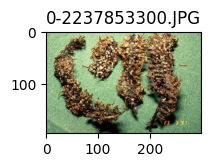

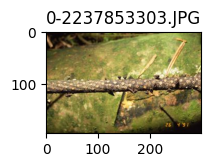

In [3]:
# visualize img data
load_data.preview_data()

In [4]:
# and tabular data
train_metadata = load_data.csv_data("train")
test_metadata = load_data.csv_data("test")
val_metadata = load_data.csv_data("val")

In [5]:
train_metadata

eventDate  year  month   day  \
0     2021-01-24  2021    1.0  24.0   
1     2021-02-27  2021    2.0  27.0   
2     2021-02-27  2021    2.0  27.0   
3     2021-02-27  2021    2.0  27.0   
4     2021-02-27  2021    2.0  27.0   
...          ...   ...    ...   ...   
7814  2021-12-18  2021   12.0  18.0   
7815  2021-12-18  2021   12.0  18.0   
7816  2021-12-30  2021   12.0  30.0   
7817  2015-06-28  2015    6.0  28.0   
7818  2015-06-28  2015    6.0  28.0   

                                                habitat countryCode  \
0     Mixed woodland (with coniferous and deciduous ...          DK   
1                                                garden          DK   
2                                                garden          DK   
3                                                garden          DK   
4                                                garden          DK   
...                                                 ...         ...   
7814                                 Deciduous woodland          DK   
7815                                 Deciduous woodland          DK   
7816                       Unmanaged deciduous woodland          DK   
7817                                        salt meadow          DK   
7818                                        salt meadow          DK   

                                         scientificName   kingdom  \
0                Xylohypha ferruginosa (Corda) S.Hughes     Fungi   
1                          Comatricha alta Preuss, 1851  Protozoa   
2                          Comatricha alta Preuss, 1851  Protozoa   
3                          Comatricha alta Preuss, 1851  Protozoa   
4                          Comatricha alta Preuss, 1851  Protozoa   
...                                                 ...       ...   
7814                Plagiosphaera immersa (Trail) Petr.     Fungi   
7815                Plagiosphaera immersa (Trail) Petr.     Fungi   
7816  Mycobernardia incrustans (Parmasto) Ghobad-Nejhad     Fungi   
7817                        Laboulbenia curtipes Thaxt.     Fungi   
7818                        Laboulbenia curtipes Thaxt.     Fungi   

             phylum               class  ... observationID       region  \
0        Ascomycota      Eurotiomycetes  ...    3052832307     Sjælland   
1         Mycetozoa         Myxomycetes  ...    3061954303  Hovedstaden   
2         Mycetozoa         Myxomycetes  ...    3061954303  Hovedstaden   
3         Mycetozoa         Myxomycetes  ...    3061954303  Hovedstaden   
4         Mycetozoa         Myxomycetes  ...    3061954303  Hovedstaden   
...             ...                 ...  ...           ...          ...   
7814     Ascomycota     Sordariomycetes  ...    4100093368  Hovedstaden   
7815     Ascomycota     Sordariomycetes  ...    4100093368  Hovedstaden   
7816  Basidiomycota      Agaricomycetes  ...    3429079314     Sjælland   
7817     Ascomycota  Laboulbeniomycetes  ...    4847339663          NaN   
7818     Ascomycota  Laboulbeniomycetes  ...    4847339663          NaN   

       district          filename  category_id   metaSubstrate poisonous  \
0       Næstved  0-3052832307.JPG         2421            wood         0   
1      Gribskov  0-3061954303.JPG          386            wood         0   
2      Gribskov  1-3061954303.JPG          386            wood         0   
3      Gribskov  2-3061954303.JPG          386            wood         0   
4      Gribskov  3-3061954303.JPG          386            wood         0   
...         ...               ...          ...             ...       ...   
7814  Rudersdal  0-4100093368.JPG         1736  plant material         0   
7815  Rudersdal  2-4100093368.JPG         1736  plant material         0   
7816       Sorø  2-3429079314.JPG         1465            wood         0   
7817        NaN  0-4847339663.JPG         1166         animals         0   
7818        NaN  1-4847339663.JPG         1166         animals         0   

     elevation  landcover  biogeographical

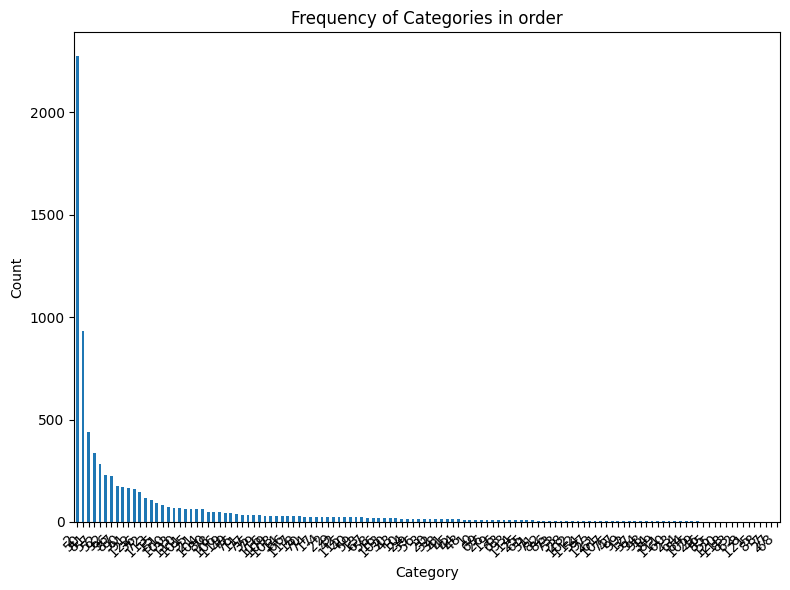

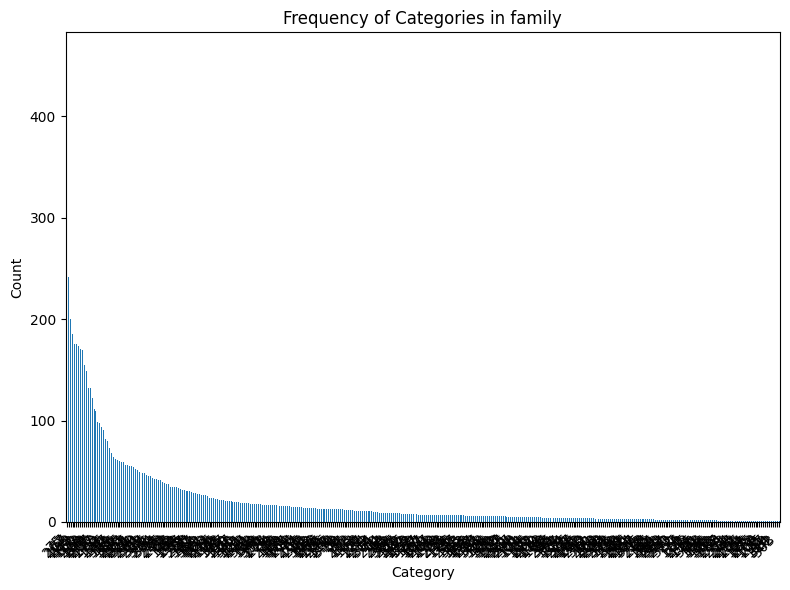

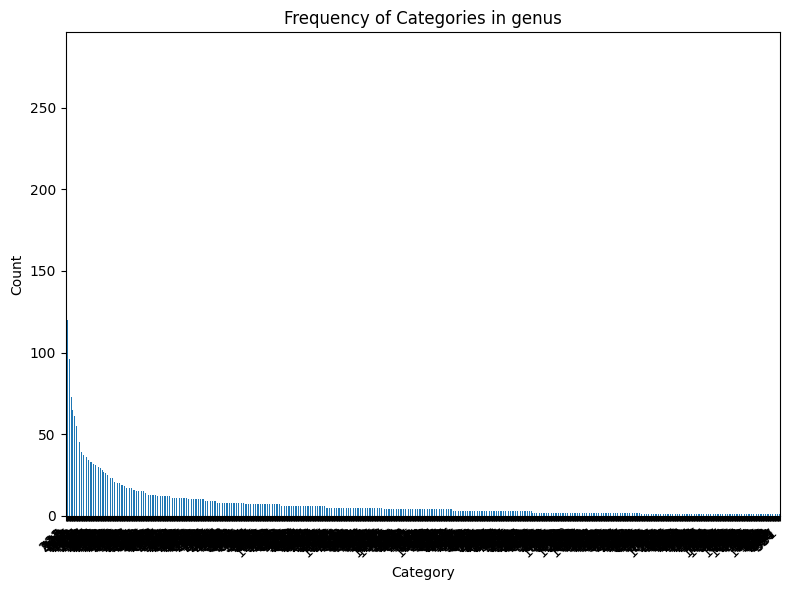

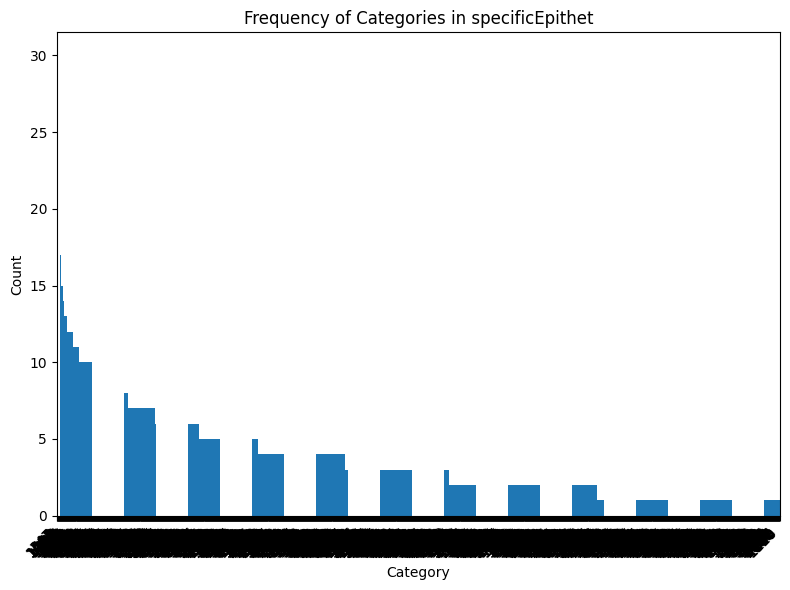

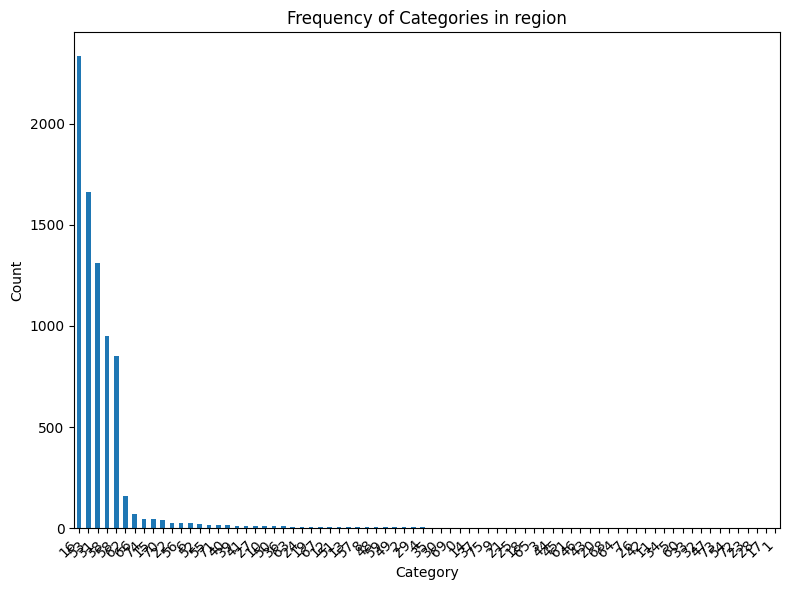

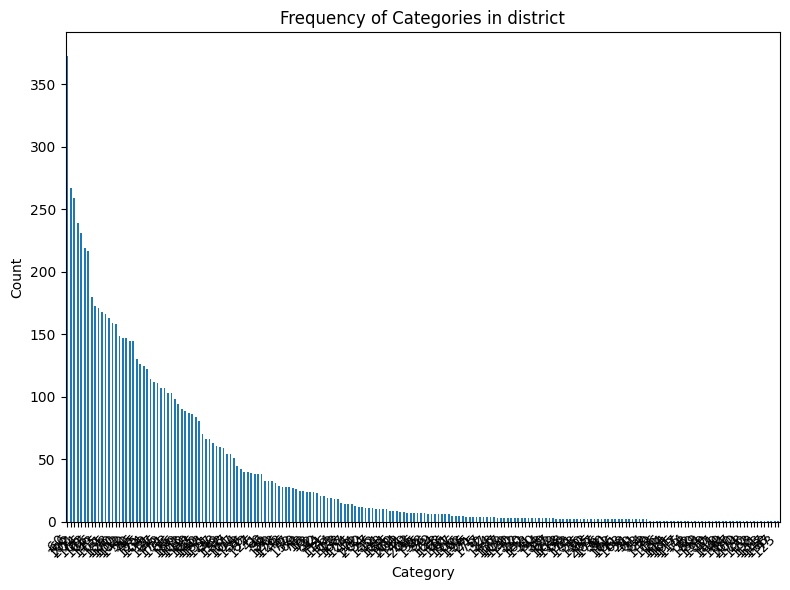

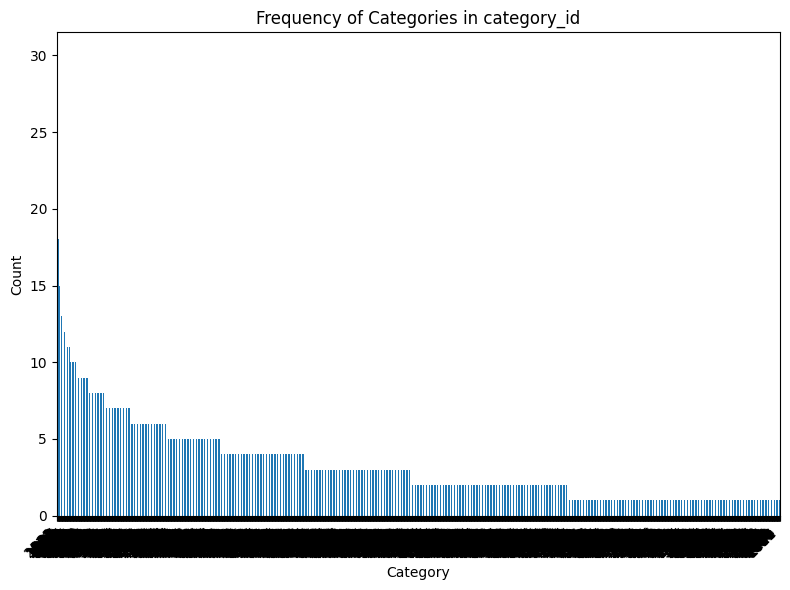

In [6]:
# identify if data is skewed
load_data.visualize_categories('train')

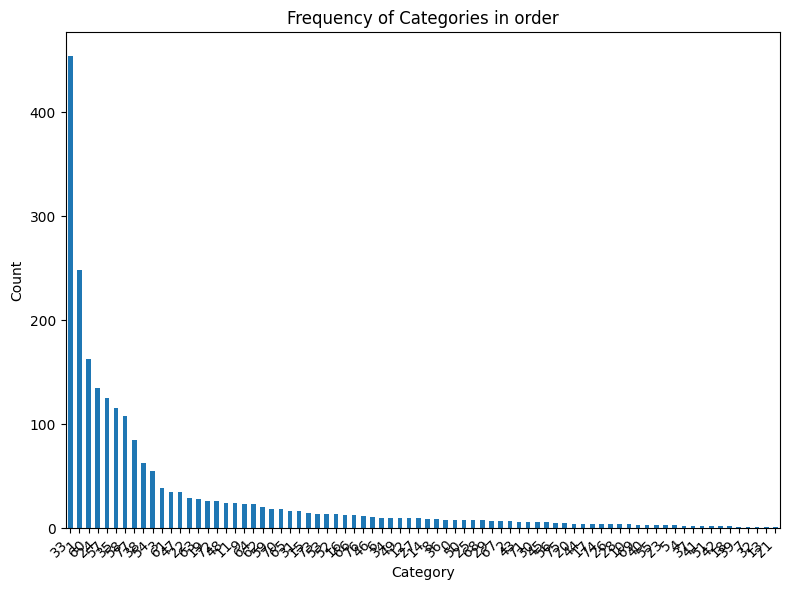

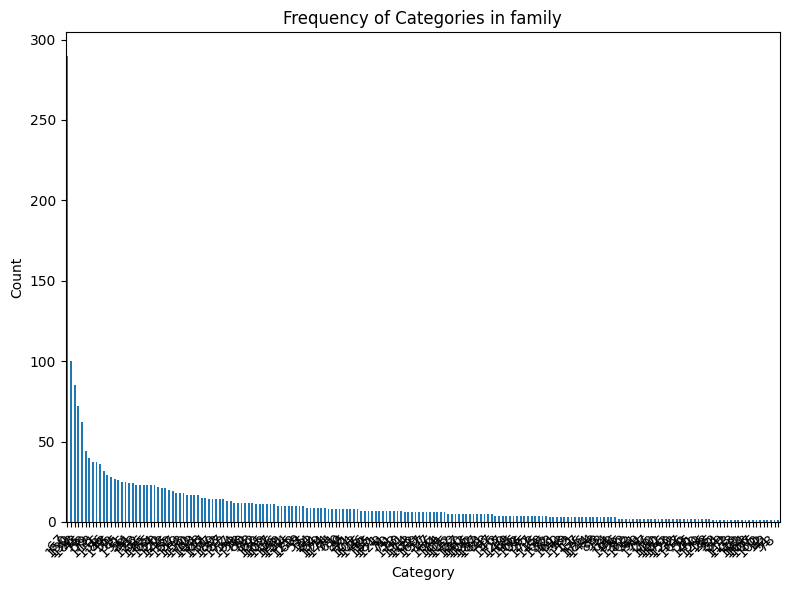

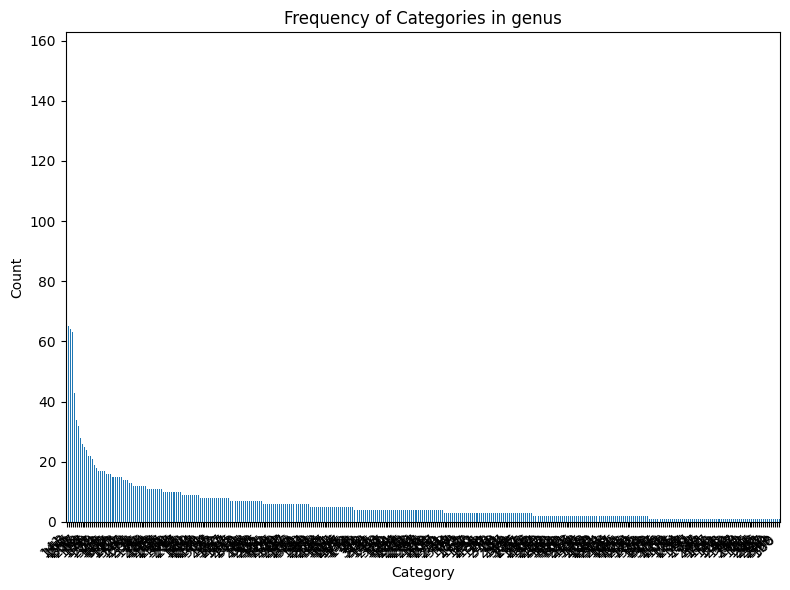

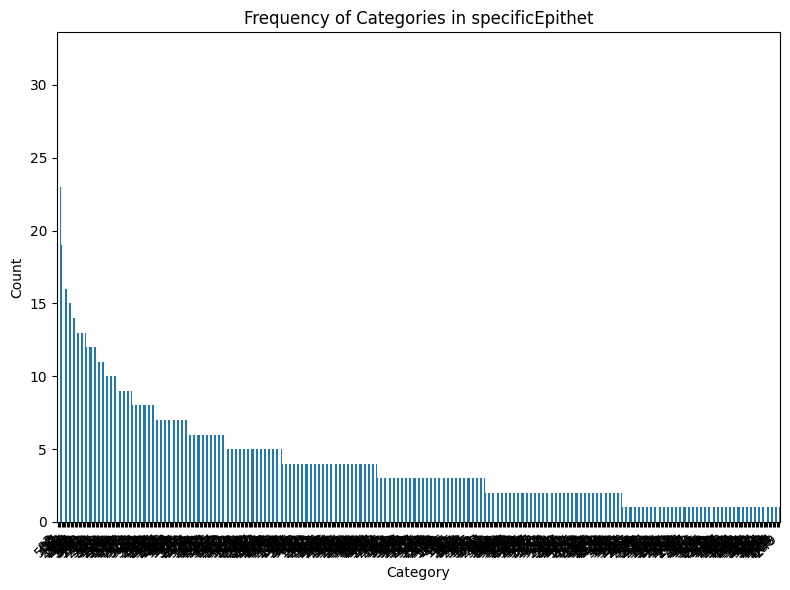

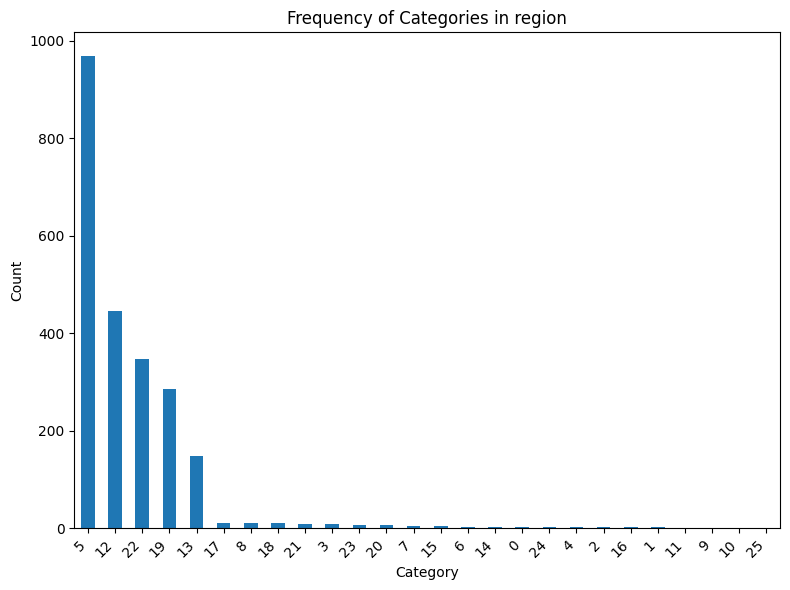

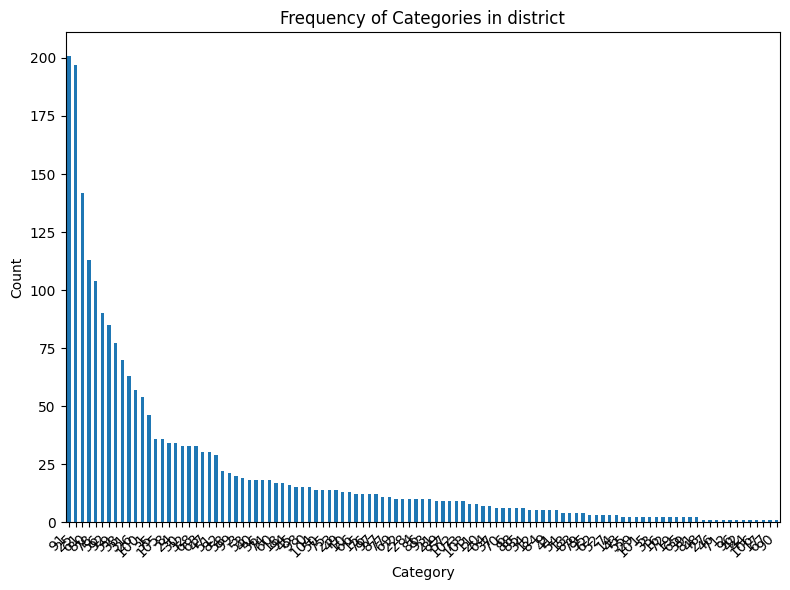

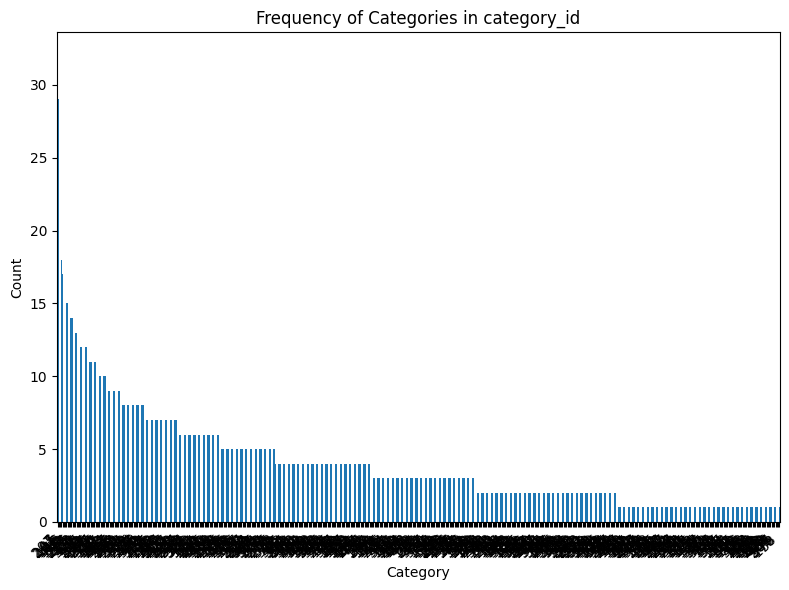

In [7]:
# identify if data is skewed
load_data.visualize_categories('val')

##⛽**2: Preprocess & Explore the Data**

**Image sets:** Start with 300px or 500px images for quicker experimentation.

**Metadata:** Normalize categorical fields (habitat, substrate), encode timestamps (month/day), and parse EXIF features.

**Satellite images & captions:** Treat these as separate input modalities for later fusion.

**Class imbalance:** Compute class frequencies and identify rare classes.

In [ ]:
train_transform = v2.Compose([
    v2.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01),
    v2.RandomAffine(degrees=5, translate=(0.02, 0.02), scale=(0.95, 1.05)),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# perform preprocessing on img data and tabular
ds_train = MultimodalDataset('train',res=300)
ds_test = MultimodalDataset('test',res=300)
ds_val = MultimodalDataset('val',res=300)

z:\GMU\spring25\CS482-002\FungiClef-25\fungi_dataloader.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return image, torch.tensor(tabular), torch.tensor(label)


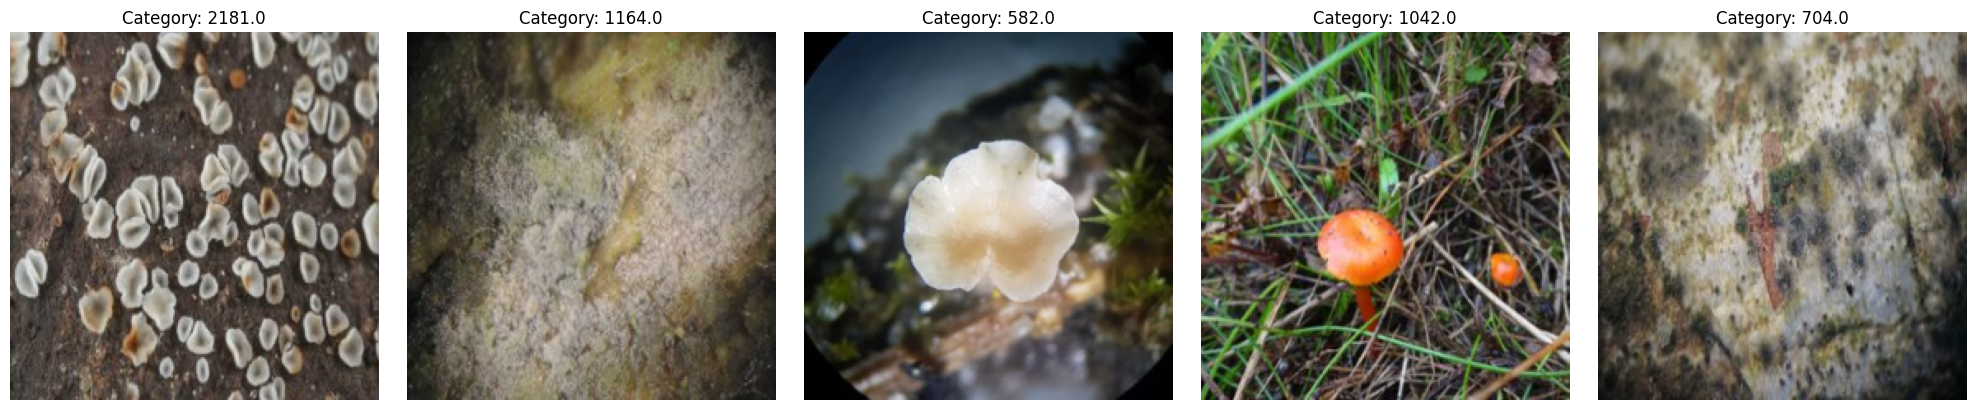

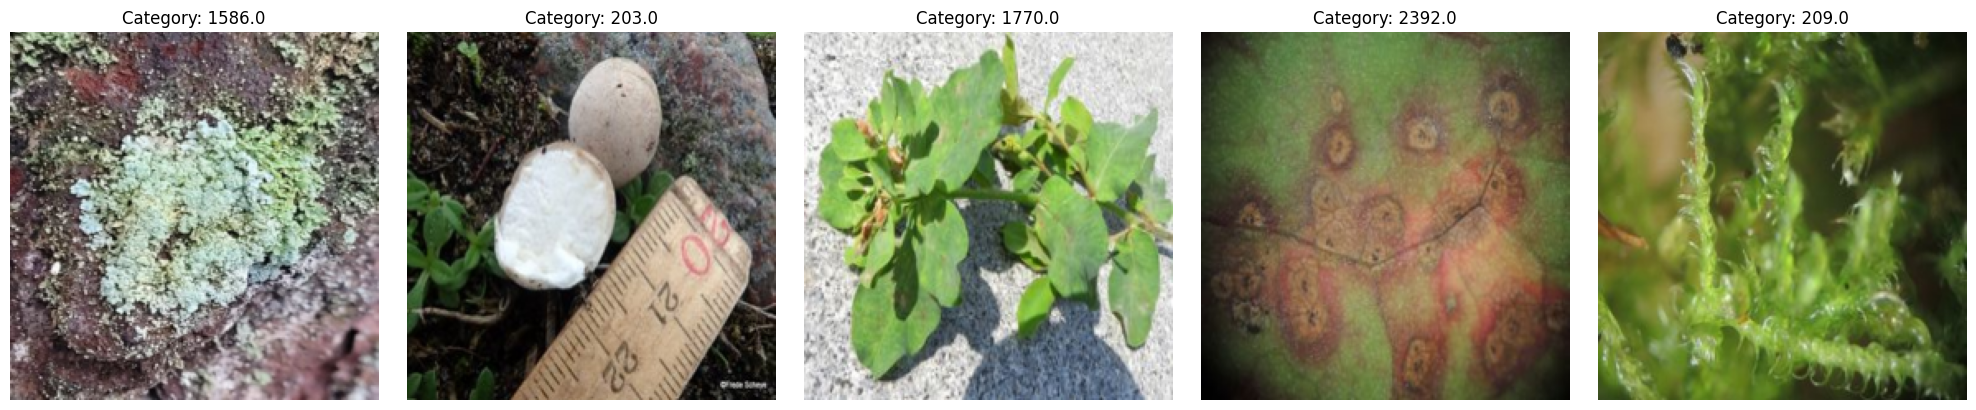

z:\GMU\spring25\CS482-002\FungiClef-25\fungi_dataloader.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return image, torch.tensor(tabular)


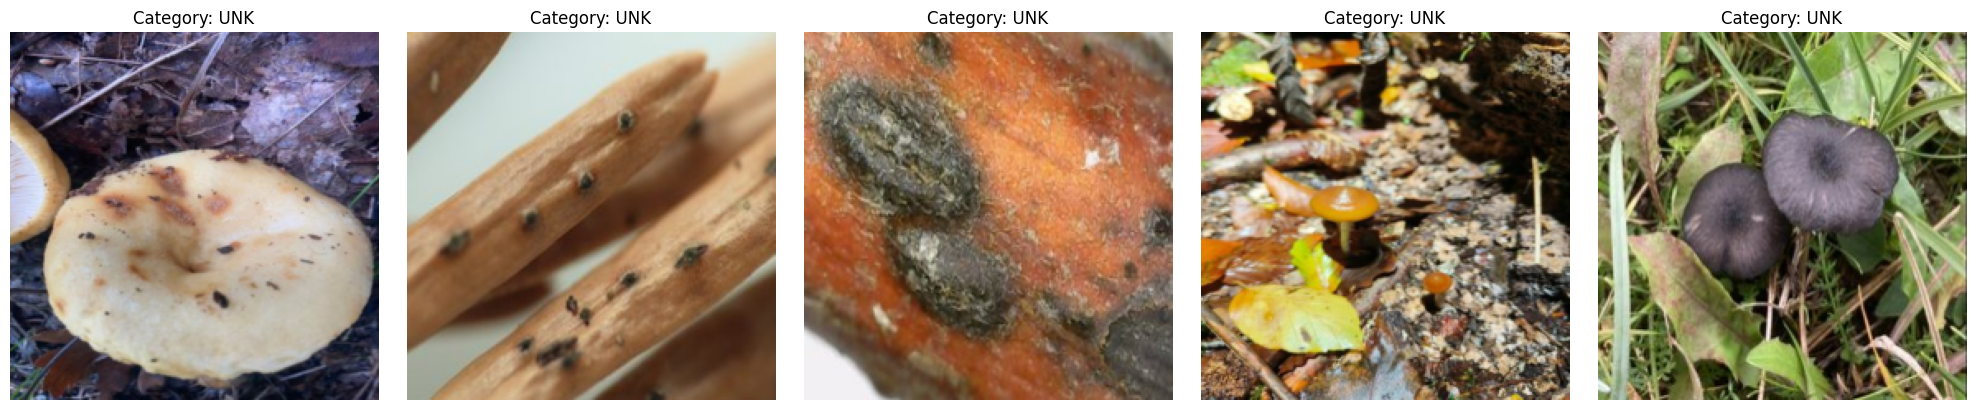

In [9]:
ds_train.visualize_data()
ds_val.visualize_data()
ds_test.visualize_data()

In [ ]:
# optionally download data if you really want to
# load_data.standardize_data(load_data.csv_data('train')).to_csv('train_metadata.csv',index=False)
# load_data.standardize_data(load_data.csv_data('test')).to_csv('test_metadata.csv',index=False)
# load_data.standardize_data(load_data.csv_data('val')).to_csv('val_metadata.csv',index=False)

In [11]:
# (optional) encode metadata

##**3: Base Modeling**

**Image model:** Use a pre-trained image encoder (e.g. EfficientNet, ConvNeXt, or a ViT variant) fine-tuned on your dataset.

**Metadata model:** MLP over tabular features (or transformer if complex). Normalize numerical fields.

**Combine:** Late fusion — combine image and metadata logits before ranking predictions.

**Loss:** Use cross-entropy with class re-weighting or focal loss to boost rare class signal.

In [12]:
# base model

##**4: Improve Recall@5 (Core Metric)**

**Multi-label softmax + top-k selection:** Ensure your model predicts scores for all classes, then evaluate Top-5 accuracy.

**Labelling:** Apply label smoothing or mixup to improve generalization.

**Classification:** Use cosine classifier or ArcFace for better separation in embedding space.

In [13]:
# improve recall

##**5: Handling Rare Classes**

**Data augmentation:** Use strong augmentations (RandAugment, CutMix, etc.).

**External data:** Use semi-supervised learning (e.g., pseudo-labeling) if allowed by rules.

***Use class prototypes or nearest neighbor matching from image embeddings to help model similarity across species.*

In [14]:
# rare cases

##**6: Captions & Satellite Data**

**Captions:** Encode using a text transformer (e.g., BERT or CLIP text encoder) and fuse with image features.

**Satellite data:** Use a small CNN or ViT variant to extract environmental embeddings.

**Fusion:** Concatenate embeddings (early fusion) or fuse logits (late fusion). Try attention-based fusion for best performance.

##**7: Train & Validate**

**Stratified sampling for cross-validation:** Ensure rare classes are seen.

**Train:** Train with multi-task loss (e.g., predict both species and toxicity) for auxiliary signal.

**Recall@5:** Evaluate with Recall@5 consistently — this is your main optimization target.



##**8: Submission Pipeline**

For each observation:

Aggregate predictions across multiple images.

Return top-5 ranked species labels.

Format correctly using the sample submission file.